# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset from Kaggle competition challenges you to predict the final price of each home.

# Requirements

- Train, validate (using a dedicated validation set) and submit a linear regression model.
- Train, validate (using a dedicated validation set) and submit a random forest regressor model.
- Achieve a score better than 0.14 on the public leaderboard.

# Evaluation criteria

- Public leaderboard score
- How simple is the model
- Code quality

# Data cleaning

In [76]:
import eli5
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set_theme()
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures

from functions import unbalanced_features, feature_selector, alpha_selector

In [77]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [78]:
msno.bar(train_data, labels=True, fontsize=12);

In [79]:
msno.bar(test_data, labels=True, fontsize=12);

In the very beginning I have decided entirely to drop Alley, PoolQC, Fence and MiscFeature features because majority of values were missing.

In [80]:
features_to_drop = ["Id", "Alley", "PoolArea", "PoolQC", "Fence", "MiscFeature"]
cleaned_train_data = train_data.drop(columns=features_to_drop)
cleaned_test_data = test_data.drop(columns=features_to_drop)

Assuming that majority of lot areas in one neighborhood are more or less similar, I have filled missing values in LotFrontage column by most frequent value of particular neighborhood. 

In [81]:
fill_mode = lambda x: x.value_counts().index[0]

cleaned_train_data["LotFrontage"] = cleaned_train_data["LotFrontage"].fillna(cleaned_train_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))
cleaned_test_data["LotFrontage"] = cleaned_test_data["LotFrontage"].fillna(cleaned_test_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))

In [82]:
print("Most frequent value in MasVnrType column:", cleaned_train_data["MasVnrType"].mode()[0])
print("Most frequent value in MasVnrAre column:", cleaned_train_data["MasVnrArea"].mode()[0])

Most frequent value in MasVnrType column: None
Most frequent value in MasVnrAre column: 0.0


In [83]:
print("Number of most frequent value in MasVnrType column:", cleaned_train_data[cleaned_train_data["MasVnrType"] == "None"].shape[0])
print("Number of most frequent value in MasVnrAre column:", cleaned_train_data[cleaned_train_data["MasVnrArea"] == 0.0].shape[0])

Number of most frequent value in MasVnrType column: 864
Number of most frequent value in MasVnrAre column: 861


More than a half of values in both MasVnrType and MasVnrAre columns are None or 0.0 respectively. Also I made a technical assumption that masonry type depends on RoofStyle, RoofMatl and Exterior1st or vice versa. So the most frequent values of latter features, which also are values of coresponding rows with missing values in MasVnrType and MasVnrAre columns, are None and 0.0.

In [84]:
cleaned_train_data["MasVnrType"] = cleaned_train_data["MasVnrType"].fillna("None")
cleaned_train_data["MasVnrArea"] = cleaned_train_data["MasVnrArea"].fillna(0.0)

cleaned_test_data["MasVnrType"] = cleaned_test_data["MasVnrType"].fillna("None")
cleaned_test_data["MasVnrArea"] = cleaned_test_data["MasVnrArea"].fillna(0.0)

About 40 values are missing which are related to the features of basement and according to data the description file this means that the house has no basement, so I have changed these NA values to None.

In [85]:
basement_features = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

for feature in basement_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

Electrical feature's column is missing just one value, so I have replaced it with most frequent value.

In [86]:
cleaned_train_data["Electrical"] = cleaned_train_data["Electrical"].fillna(cleaned_train_data["Electrical"].value_counts().index[0])

NA value in the FireplaceQu column means that house has no fireplace, so I have changed these NA values to None.

In [87]:
cleaned_train_data["FireplaceQu"] = cleaned_train_data["FireplaceQu"].fillna("None")
cleaned_test_data["FireplaceQu"] = cleaned_test_data["FireplaceQu"].fillna("None")

NA values in features which are related to garage also corresponds that house has no garage, so I have changed these NA values to None.

In [88]:
garage_features = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

for feature in garage_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

## Imbalanced features

In [89]:
frequent_train_values = unbalanced_features(cleaned_train_data)

In [90]:
frequent_train_values.head()

,Feature Name,QTY of most freq. value,% of Total Values
7,Utilities,1459,99.931507
4,Street,1454,99.589041
12,Condition2,1445,98.972603
67,3SsnPorch,1436,98.356164
43,LowQualFinSF,1434,98.219178


Some features have values which amounts to more than 95 percentage of total values. Such homogeneity is useless for the models so it is better to drop those columns.

In [91]:
frequent_train_features = frequent_train_values[frequent_train_values["% of Total Values"] > 95]["Feature Name"].to_list()

cleaned_train_data = cleaned_train_data.drop(columns=frequent_train_features)
cleaned_test_data = cleaned_test_data.drop(columns=frequent_train_features)

In [92]:
msno.bar(cleaned_train_data, labels=True, fontsize=12);

## Missing values of test set 

In [93]:
msno.bar(cleaned_test_data, labels=True, fontsize=12);

Some columns in test set are missing just one or two values, so I have simply filled these missing values with most frequent values in those columns.

In [94]:
missing_test_features = [column for column in cleaned_test_data if cleaned_test_data[column].isna().any() == True]

In [95]:
for feature in missing_test_features:
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna(cleaned_test_data[feature].value_counts().index[0])

In [96]:
msno.bar(cleaned_test_data, labels=True, fontsize=12);

# Exploratory data analysis

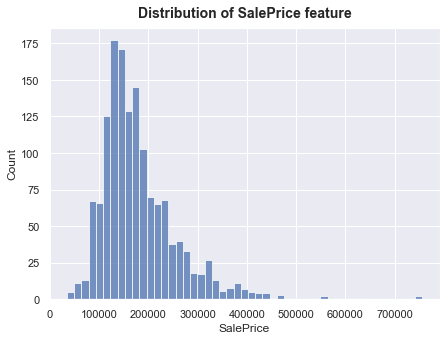

In [97]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(ax=ax, data=cleaned_train_data, x="SalePrice")
plt.title("Distribution of SalePrice feature", fontsize=14, fontweight="bold", pad=10);

We can notice some SalePrice values which are more apart than most of the values, but it's not outliers as we can see in the scatterplot below. 

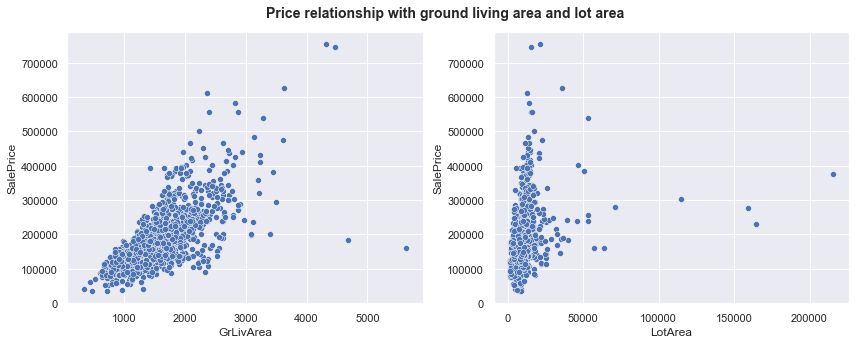

In [98]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(ax=axes[0], data=cleaned_train_data, x="GrLivArea", y="SalePrice")
sns.scatterplot(ax=axes[1], data=cleaned_train_data, x="LotArea", y="SalePrice")
fig.suptitle("Price relationship with ground living area and lot area", y=0.95, fontsize=14, fontweight="bold");

In GrLivArea vs. SalePrice graph are two not logic values where price is very low compared to GrLivArea value. Also in LotArea vs. SalePrice graph are obvious outliers above 100000 LotArea values. So I have decided to remove aforementioned values and after submission linear regression score was almost twice better but random forest score was slightly worse, but it is worth to leave this change due to improvement on linear regression model.

In [99]:
cleaned_train_data.drop(cleaned_train_data[(cleaned_train_data["GrLivArea"] > 4000) & (cleaned_train_data["SalePrice"] < 200000)].index, inplace=True)

In [100]:
cleaned_train_data.drop(cleaned_train_data[cleaned_train_data["LotArea"] > 100000].index, inplace=True)

In [101]:
cleaned_train_data = cleaned_train_data.reset_index().drop(columns="index")

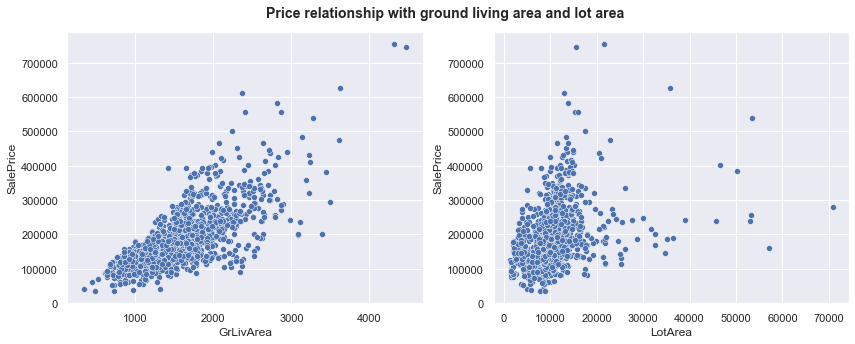

In [102]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.scatterplot(ax=axes[0], data=cleaned_train_data, x="GrLivArea", y="SalePrice")
sns.scatterplot(ax=axes[1], data=cleaned_train_data, x="LotArea", y="SalePrice")
fig.suptitle("Price relationship with ground living area and lot area", y=0.95, fontsize=14, fontweight="bold");

# Feature engineering

## Feature encoding

### Imbalanced features

In [105]:
train_encoded_data = cleaned_train_data.copy()
test_encoded_data = cleaned_test_data.copy()

I have filtered and visualized so called imbalanced features where quantity of one value is very big - from 75 pct. to 95 pct. of all values. My idea was to see if I can to merge scarce variables. Some features had better impact to score and some not.

In [107]:
train_unbalanced_table = unbalanced_features(train_encoded_data)
frequent_train_features_over_75 = train_unbalanced_table[(train_unbalanced_table["% of Total Values"] > 75) & (train_unbalanced_table["% of Total Values"] < 95)]["Feature Name"].to_list()

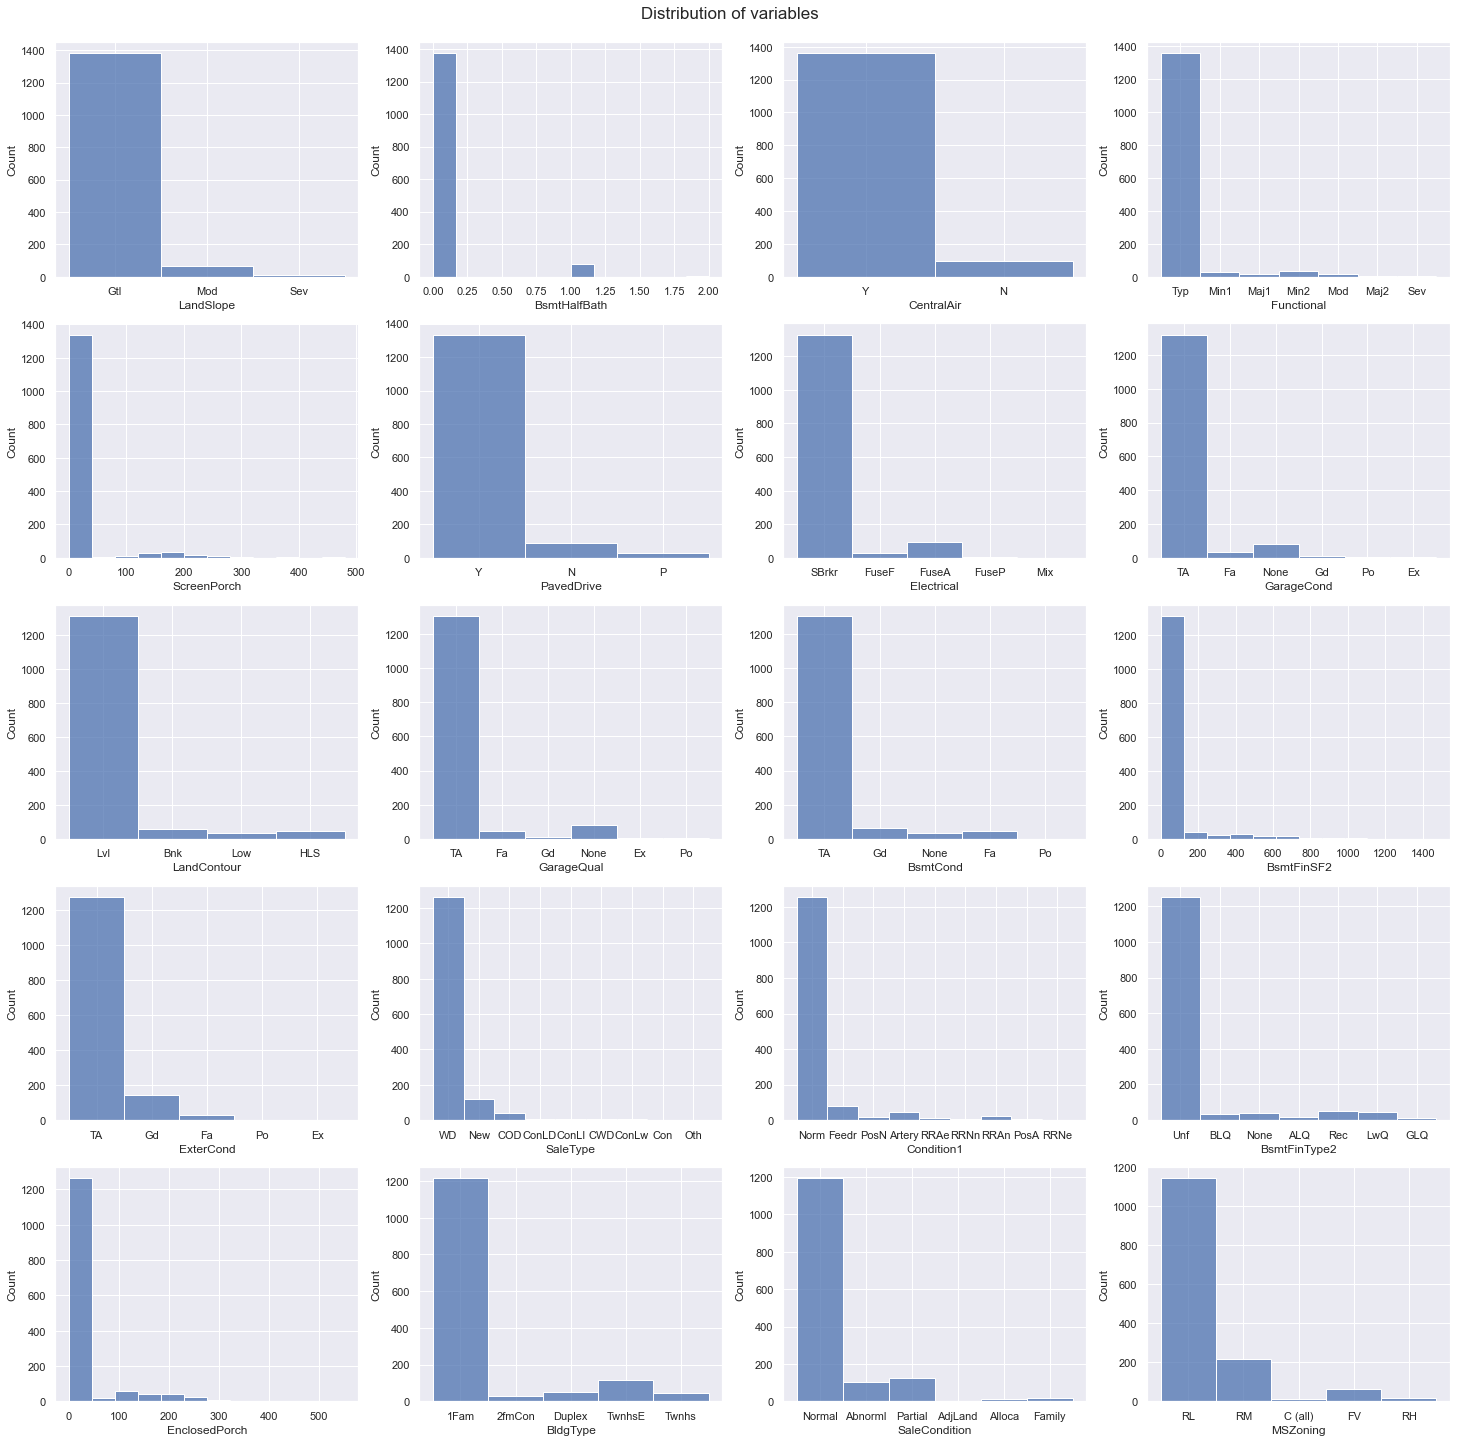

In [108]:
fig, axes = plt.subplots(5, 4, figsize=(25, 25))
fig.suptitle("Distribution of variables", y=0.9, fontsize=17)

for feature, ax in zip(frequent_train_features_over_75, axes.flatten()):
    sns.histplot(ax=ax, data=train_encoded_data, x=feature)

Features that worked:
- Functional
- Electrical
- LandContour
- Condition1
- Exterior1st
- Exterior2nd
- LotShape
- SaleType

Features that didn't work:
- LandSlope
- BsmtHalfBath
- Convert ScreenPorch feature to binary Y/N format
- MSZoning

In [109]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Functional"] = dataset["Functional"].replace(["Min1", "Min2"], "Min")
    dataset["Functional"] = dataset["Functional"].replace(["Maj1", "Maj2"], "Maj")

In [110]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Electrical"] = dataset["Electrical"].replace(["FuseA", "FuseF", "FuseP"], "Fuse")

In [111]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["LandContour"] = dataset["LandContour"].replace("Lvl", "Flat")
    dataset["LandContour"] = dataset["LandContour"].replace(["Bnk", "HLS", "Low"], "NotFlat")

In [112]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Condition1"] = dataset["Condition1"].replace(["RRAn", "RRAe", "RRNn", "RRNe"], "RR")
    dataset["Condition1"] = dataset["Condition1"].replace(["PosN", "PosA"], "Pos")
    dataset["Condition1"] = dataset["Condition1"].replace(["Feedr", "Artery"], "Street")

In [113]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["VinylSd", "MetalSd"], "Sd")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["WdShing", "AsbShng", "AsphShn"], "Pos")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["CemntBd", "HdBoard"], "Board")
    dataset["Exterior1st"] = dataset["Exterior1st"].replace(["BrkComm", "BrkFace"], "Brick")

In [114]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["VinylSd", "MetalSd", "Wd Sdng"], "Sd")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["Wd Shing", "AsbShng", "AsphShn"], "Pos")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["CmentBd", "HdBoard"], "Board")
    dataset["Exterior2nd"] = dataset["Exterior2nd"].replace(["BrkComm", "BrkFace"], "Brick")

In [115]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["LotShape"] = dataset["LotShape"].replace(["IR1", "IR2", "IR3"], "IR")

In [116]:
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["SaleType"] = dataset["SaleType"].replace(["CWD", "VWD"], "WD")
    dataset["SaleType"] = dataset["SaleType"].replace(["ConLw", "ConLD", "ConLI"], "Con")

### Mapping

Some categorical features have clear order, therefore I have decided to map that values with numbers in sequence. 

In [117]:
quality_mapping = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
quality_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "HeatingQC"]

for feature in quality_features:
    train_encoded_data[feature] = train_encoded_data[feature].map(quality_mapping)
    test_encoded_data[feature] = test_encoded_data[feature].map(quality_mapping)

In [118]:
basement_rating_mapping = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
basement_rating_features = ["BsmtFinType1", "BsmtFinType2"]

for feature in basement_rating_features:
    train_encoded_data[feature] = train_encoded_data[feature].map(basement_rating_mapping)
    test_encoded_data[feature] = test_encoded_data[feature].map(basement_rating_mapping)

In [119]:
central_air_mapping = {"N": 0, "Y": 1}
train_encoded_data["CentralAir"] = train_encoded_data["CentralAir"].map(central_air_mapping)
test_encoded_data["CentralAir"] = test_encoded_data["CentralAir"].map(central_air_mapping)

In [120]:
garage_finish_mapping = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
train_encoded_data["GarageFinish"] = train_encoded_data["GarageFinish"].map(garage_finish_mapping)
test_encoded_data["GarageFinish"] = test_encoded_data["GarageFinish"].map(garage_finish_mapping)

In [121]:
ordinal_features = ["SalePrice", "GarageFinish", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "HeatingQC",
                    "BsmtFinType1", "BsmtFinType2", "CentralAir"]

ordinal_data = train_encoded_data[ordinal_features].copy()

After poor results of trying to improve score, I have decided closely to look at the mapped features. As I thought not all features which were related to quality correlated with price, that is to say better is not equal higher price, therefore I have to unmap those features. Also I have noticed that GarageQual is highly correlating with GarageCond, so I can delete one of those.

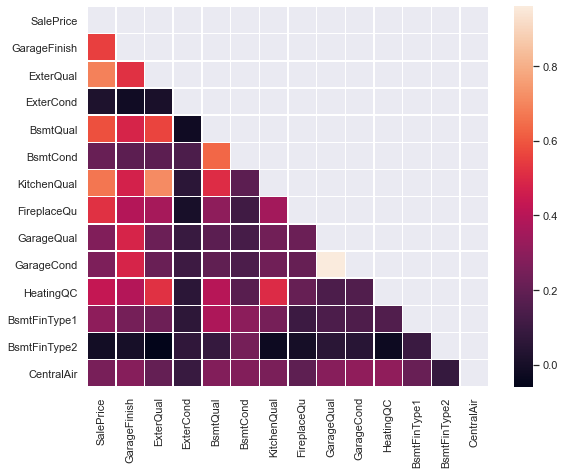

In [122]:
corr = ordinal_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, mask=mask, linewidths=.5);

In [123]:
quality_unmapping = {0: "None", 1: "Po", 2: "Fa", 3: "TA", 4: "Gd", 5: "Ex"}

train_encoded_data["ExterCond"] = train_encoded_data["ExterCond"].map(quality_unmapping)
test_encoded_data["ExterCond"] = test_encoded_data["ExterCond"].map(quality_unmapping)

In [124]:
basement_rating_unmapping = {0: "None", 1: "Unf", 2: "LwQ", 3: "Rec", 4: "BLQ", 5: "ALQ", 6: "GLQ"}

train_encoded_data["BsmtFinType2"] = train_encoded_data["BsmtFinType2"].map(basement_rating_unmapping)
test_encoded_data["BsmtFinType2"] = test_encoded_data["BsmtFinType2"].map(basement_rating_unmapping)

In [125]:
train_encoded_data = train_encoded_data.drop(columns="GarageQual")
test_encoded_data = test_encoded_data.drop(columns="GarageQual")

## Artificial features

The feature GarageYrBlt itself is not so usefull for modelling because it shouldn't be treated like mere number and it's better to use duration metric. I have also converted to duration YearBuilt feature.

In [126]:
train_encoded_data["GarageYrBlt"] = train_encoded_data["GarageYrBlt"].replace("None", 0)
test_encoded_data["GarageYrBlt"] = test_encoded_data["GarageYrBlt"].replace("None", 0)

In [127]:
train_encoded_data["GarageAge"] = train_encoded_data["YrSold"] - train_encoded_data["GarageYrBlt"].astype("int64")
test_encoded_data["GarageAge"] = test_encoded_data["YrSold"] - test_encoded_data["GarageYrBlt"].astype("int64")

train_encoded_data = train_encoded_data.drop(columns="GarageYrBlt")
test_encoded_data = test_encoded_data.drop(columns="GarageYrBlt")

In [128]:
train_encoded_data["YearAge"] = train_encoded_data["YrSold"] - train_encoded_data["YearBuilt"].astype("int64")
test_encoded_data["YearAge"] = test_encoded_data["YrSold"] - test_encoded_data["YearBuilt"].astype("int64")

train_encoded_data = train_encoded_data.drop(columns="YearBuilt")
test_encoded_data = test_encoded_data.drop(columns="YearBuilt")

The main ideas for artificial features came from ELI5 table with weights of features, where I could see the most important ones.

The quality and condition are rated from 1 to 10, so I have decided to sum these rates.

In [132]:
train_encoded_data["OverallQualandCond"] = train_encoded_data["OverallQual"] + train_encoded_data["OverallCond"]
test_encoded_data["OverallQualandCond"] = test_encoded_data["OverallQual"] + test_encoded_data["OverallCond"]

TotalHouseArea is a new feature which sums up all distinct part of the house.

In [133]:
house_area_features = ["TotalBsmtSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "ScreenPorch"]
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    dataset["TotalHouseArea"] = 0
    for feature in house_area_features:
        dataset["TotalHouseArea"] += dataset[feature]


AreaQuality - it's metric which is related to the total area and overall quality of the house.

In [134]:
train_encoded_data["AreaQuality"] = train_encoded_data["TotalHouseArea"] * train_encoded_data["OverallQual"]
test_encoded_data["AreaQuality"] = test_encoded_data["TotalHouseArea"] * test_encoded_data["OverallQual"]

Another similar feature AreaAge is related to total area and house age.

In [135]:
train_encoded_data["AreaAge"] = train_encoded_data["TotalHouseArea"] * train_encoded_data["YearAge"]
test_encoded_data["AreaAge"] = test_encoded_data["TotalHouseArea"] * test_encoded_data["YearAge"]

And few last features were created by applying the square root to the features, which metrics are in square feet. 

In [136]:
sqrt_features = ["GrLivArea", "TotalBsmtSF", "LotArea", "1stFlrSF", "2ndFlrSF", "MasVnrArea", "TotalHouseArea"]
combined_encoded = [train_encoded_data, test_encoded_data]

for dataset in combined_encoded:
    for feature in sqrt_features:
        dataset[f"{feature}_Sqrt"] = np.sqrt(dataset[feature])

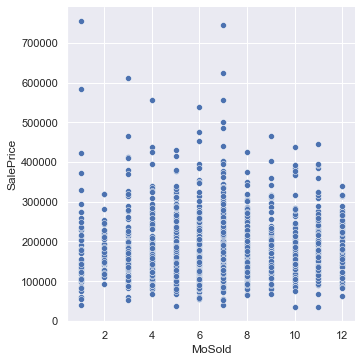

In [129]:
sns.relplot(y="SalePrice", x="MoSold", data=train_encoded_data);

In [130]:
train_encoded_data[["MoSold", "SalePrice"]].corr()

,MoSold,SalePrice
MoSold,1.000000,0.046459
SalePrice,0.046459,1.000000


In the very end I have deleted MoSold column, because I have done the assumption that month is not relevant to the price, as you can see it in the graph and correlation table.

In [131]:
train_encoded_data = train_encoded_data.drop(columns="MoSold")
test_encoded_data = test_encoded_data.drop(columns="MoSold")

## Polynomial features

In [137]:
train_numerical_features = [column for column in train_encoded_data if (train_encoded_data[column].dtypes == "int64") or (train_encoded_data[column].dtypes == "int64")]
test_numerical_features = [column for column in test_encoded_data if (test_encoded_data[column].dtypes == "int64") or (test_encoded_data[column].dtypes == "int64")]

not_polynomial_features = ["SalePrice", "AreaQuality", "AreaAge"]

for feature in not_polynomial_features:
    train_numerical_features.remove(feature)

In [138]:
train_polynomial = PolynomialFeatures(2, include_bias=False)
test_polynomial = PolynomialFeatures(2, include_bias=False)

In [139]:
train_polynomial_array = train_polynomial.fit_transform(train_encoded_data[train_numerical_features])
test_polynomial_array = test_polynomial.fit_transform(test_encoded_data[test_numerical_features])

train_polynomial_data = pd.DataFrame(train_polynomial_array, columns=train_polynomial.get_feature_names(train_numerical_features))
test_polynomial_data = pd.DataFrame(test_polynomial_array, columns=test_polynomial.get_feature_names(test_numerical_features))

In [140]:
train_features = [column for column in train_encoded_data]
test_features = [column for column in test_encoded_data]

train_polynomial_data = train_polynomial_data.drop(columns=train_features, errors="ignore")
test_polynomial_data = test_polynomial_data.drop(columns=test_features, errors="ignore")

In [141]:
train_encoded_polynomial_data = train_encoded_data.join(train_polynomial_data)
test_encoded_polynomial_data = test_encoded_data.join(test_polynomial_data)

### One-hot encoding

In [142]:
categorical_train_features = [column for column in train_encoded_data if train_encoded_data[column].dtypes == "object"]
categorical_test_features = [column for column in test_encoded_data if test_encoded_data[column].dtypes == "object"]

train_oh_encoded_data = pd.get_dummies(train_encoded_data, columns=categorical_train_features)
test_oh_encoded_data = pd.get_dummies(test_encoded_data, columns=categorical_test_features)

In [143]:
print("Train set columns:", train_oh_encoded_data.shape[1])
print("Test set columns:", test_oh_encoded_data.shape[1])

Train set columns: 191
Test set columns: 185


### One-hot ecoding with polynomial features

In [144]:
train_oh_encoded_polynomial_data = pd.get_dummies(train_encoded_polynomial_data, columns=categorical_train_features)
test_oh_encoded_polynomial_data = pd.get_dummies(test_encoded_polynomial_data, columns=categorical_test_features)

In [145]:
print("Columns of train set with polynomial features after one-hot encoding:", train_oh_encoded_polynomial_data.shape[1])
print("Columns of train set with polynomial features after one-hot encoding:", test_oh_encoded_polynomial_data.shape[1])

Columns of train set with polynomial features after one-hot encoding: 1011
Columns of train set with polynomial features after one-hot encoding: 681


# Modelling

## Standard models

Kaggle submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price, so the corresponding column of train set used for cross-validation shuold be in the logarithmic scale too. I am using cross-validation for checking my models, because I don't want to split train set due to it's small size. 

In [146]:
# Create sets for cross validation.
train_evaluation_data = train_oh_encoded_data.copy()
train_evaluation_data["SalePrice"] = np.log(train_evaluation_data["SalePrice"])

Test set has fewer columns after one-hot encoding due to unequal number of unique values in categorical features. To tackle this problem I have used pandas align function.  

In [147]:
final_train_data, final_test_data = train_oh_encoded_data.align(test_oh_encoded_data, join='inner', axis=1)

print("Final train set columns:", final_train_data.shape[1])
print("Final test set columns:", final_test_data.shape[1])

Final train set columns: 185
Final test set columns: 185


In [148]:
target = "SalePrice"
final_features = [column for column in final_train_data]

# Data used for cross-validation.
X_eval = train_evaluation_data[final_features]
y_eval = train_evaluation_data[target]

# Data used for model training.
X_train = final_train_data[final_features]
y_train = train_oh_encoded_data[target]

In [149]:
# Set splitting for usage in ELI5 Permuation Importance method.
train_X, val_X, train_y, val_y = train_test_split(X_eval, y_eval, random_state=42)

### Linear regression

In [150]:
linear_regression = LinearRegression()

In [151]:
lin_reg_model = linear_regression.fit(train_X, train_y)

lin_reg_perm = PermutationImportance(lin_reg_model, random_state=42).fit(val_X, val_y)
lin_reg_weights_df = eli5.explain_weights_df(lin_reg_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(lin_reg_perm, feature_names=val_X.columns.tolist(), top=10)

Weight,Feature
1.1047 ± 0.0671,TotalHouseArea_Sqrt
0.6573 ± 0.0735,TotalHouseArea
0.5051 ± 0.0629,1stFlrSF
0.3758 ± 0.0295,AreaQuality
0.3559 ± 0.0393,1stFlrSF_Sqrt
0.1563 ± 0.0202,TotalBsmtSF_Sqrt
0.0854 ± 0.0106,YearAge
0.0407 ± 0.0060,MasVnrArea_Sqrt
0.0407 ± 0.0046,Exterior1st_Sd
0.0381 ± 0.0039,TotalBsmtSF


In [152]:
# Evaluation
lin_reg_scores = cross_val_score(linear_regression, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Linear regression RMSE:", lin_reg_scores.mean())

Linear regression RMSE: -0.1122059673796186


In [153]:
lin_reg_selected_features = feature_selector(lin_reg_weights_df, 0.11239, linear_regression, train_evaluation_data, "SalePrice")

The score was improved by 0.00452
The best score: 0.10787


In [76]:
X_train_selected = final_train_data[lin_reg_selected_features]
final_test_selected_data = final_test_data[lin_reg_selected_features]

linear_regression.fit(X_train_selected, y_train)
linear_predictions = linear_regression.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": linear_predictions})
output.to_csv("submissions/linear_predictions.csv", index=False)

### Ridge regression

In [154]:
optimal_alpha = alpha_selector("Ridge", X_eval, y_eval)

The lowest reached score: 0.10878
Optimal alpha: 7.2


In [155]:
ridge_regression = Ridge(alpha=optimal_alpha)

In [156]:
ridge_model = ridge_regression.fit(train_X, train_y)

ridge_perm = PermutationImportance(ridge_model, random_state=42).fit(val_X, val_y)
ridge_weights_df = eli5.explain_weights_df(ridge_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(ridge_perm, feature_names = val_X.columns.tolist(), top=10)

Weight,Feature
0.6650 ± 0.0465,TotalHouseArea_Sqrt
0.5247 ± 0.0578,TotalHouseArea
0.3243 ± 0.0235,AreaQuality
0.1761 ± 0.0201,1stFlrSF_Sqrt
0.1357 ± 0.0105,GrLivArea_Sqrt
0.1344 ± 0.0226,1stFlrSF
0.0756 ± 0.0097,YearAge
0.0554 ± 0.0158,GrLivArea
0.0245 ± 0.0031,LotArea_Sqrt
0.0240 ± 0.0067,TotalBsmtSF_Sqrt


In [157]:
ridge_selected_features = feature_selector(ridge_weights_df, 0.10889, ridge_regression, train_evaluation_data, "SalePrice")

The score was improved by 0.00031
The best score: 0.10858


In [81]:
X_train_selected = final_train_data[ridge_selected_features]
final_test_selected_data = final_test_data[ridge_selected_features]

ridge_regression.fit(X_train_selected, y_train)
ridge_predictions = ridge_regression.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": ridge_predictions})
output.to_csv("submissions/ridge_predictions.csv", index=False)

### Lasso regression

In [158]:
optimal_alpha = alpha_selector("Lasso", X_eval, y_eval)

The lowest reached score: 0.14168
Optimal alpha: 0.1


In [159]:
lasso_regression = Lasso(alpha=optimal_alpha, max_iter=3000)

In [160]:
lasso_model = lasso_regression.fit(train_X, train_y)

lasso_perm = PermutationImportance(lasso_model, random_state=42).fit(val_X, val_y)
lasso_weights_df = eli5.explain_weights_df(lasso_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(lasso_perm, feature_names = val_X.columns.tolist(), top=10)

Weight,Feature
0.5317 ± 0.0355,AreaQuality
0.0494 ± 0.0105,YearAge
0.0418 ± 0.0138,YearRemodAdd
0.0251 ± 0.0107,2ndFlrSF
0.0197 ± 0.0058,GarageAge
0.0176 ± 0.0061,1stFlrSF
0.0149 ± 0.0073,BsmtFinSF1
0.0101 ± 0.0031,LotArea
0.0073 ± 0.0053,GrLivArea
0.0017 ± 0.0009,ScreenPorch


In [161]:
lasso_selected_features = feature_selector(lasso_weights_df, 0.14168, lasso_regression, train_evaluation_data, "SalePrice")

The score was improved by 0.00044
The best score: 0.14124


In [86]:
X_train_selected = final_train_data[lasso_selected_features]
final_test_selected_data = final_test_data[lasso_selected_features]

lasso_regression.fit(X_train_selected, y_train)
lasso_predictions = lasso_regression.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": lasso_predictions})
output.to_csv("submissions/lasso_predictions.csv", index=False)

### Random forest regressor

In [162]:
random_forest = RandomForestRegressor(random_state=42)

In [163]:
random_forest_model = random_forest.fit(train_X, train_y)

random_forest_perm = PermutationImportance(random_forest_model, random_state=42).fit(val_X, val_y)
random_forest_weights_df = eli5.explain_weights_df(random_forest_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(random_forest_perm, feature_names = val_X.columns.tolist(), top=10)

Weight,Feature
1.2489 ± 0.0732,AreaQuality
0.0095 ± 0.0016,YearAge
0.0077 ± 0.0022,YearRemodAdd
0.0051 ± 0.0012,OverallCond
0.0036 ± 0.0007,MSZoning_RM
0.0030 ± 0.0013,CentralAir
0.0029 ± 0.0012,MSZoning_RL
0.0028 ± 0.0000,MSZoning_C (all)
0.0026 ± 0.0011,TotalHouseArea
0.0022 ± 0.0011,LotArea_Sqrt


In [164]:
# Dict of various parameters to use in RandomizedSearchCV.
params = {'bootstrap': [True, False],
              "max_depth": [5, 10, 20, 30, 40, 50, None],
              "max_features": ["auto", "sqrt"],
              "min_samples_leaf": [1, 2, 4],
              "min_samples_split": [2, 5, 10],
              "n_estimators": [200, 400, 600, 800, 1000]}

In [90]:
#randomized_search = RandomizedSearchCV(estimator=random_forest, param_distributions=params, n_iter=100, scoring="neg_root_mean_squared_error")
#randomized_search.fit(X_eval, y_eval)

In [91]:
#best_params = randomized_search.best_params_

In [165]:
# Dict of the best parameters for Random forest model according to RandomizedSearchCV.
best_params = {"n_estimators": 1000,
               "min_samples_split": 2,
               "min_samples_leaf": 1,
               "max_features": "sqrt",
               "max_depth": None,
               "bootstrap": False}

In [166]:
tuned_random_forest = RandomForestRegressor(n_estimators=best_params["n_estimators"], min_samples_split=best_params["min_samples_split"],
                                            min_samples_leaf=best_params["min_samples_leaf"], max_features=best_params["max_features"],
                                            max_depth=best_params["max_depth"], bootstrap=best_params["bootstrap"])

In [167]:
tuned_random_forest_model = tuned_random_forest.fit(train_X, train_y)

tuned_random_forest_perm = PermutationImportance(tuned_random_forest_model, random_state=42).fit(val_X, val_y)
tuned_random_forest_weights_df = eli5.explain_weights_df(tuned_random_forest_perm, feature_names=val_X.columns.tolist())
eli5.show_weights(tuned_random_forest_perm, feature_names = val_X.columns.tolist(), top=10)

Weight,Feature
0.0396 ± 0.0032,AreaQuality
0.0204 ± 0.0084,TotalHouseArea
0.0201 ± 0.0056,TotalHouseArea_Sqrt
0.0135 ± 0.0026,OverallQualandCond
0.0128 ± 0.0037,OverallQual
0.0115 ± 0.0046,GrLivArea
0.0103 ± 0.0035,GrLivArea_Sqrt
0.0077 ± 0.0040,YearAge
0.0058 ± 0.0017,KitchenQual
0.0054 ± 0.0024,YearRemodAdd


In [168]:
random_forest_scores = cross_val_score(random_forest, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Random forest regressor RMSE:", random_forest_scores.mean())

Random forest regressor RMSE: -0.12978374300525464


In [169]:
tuned_random_forest_scores = cross_val_score(tuned_random_forest, X_eval, y_eval, scoring="neg_root_mean_squared_error")
print("Tuned Random forest regressor RMSE:", tuned_random_forest_scores.mean())

Tuned Random forest regressor RMSE: -0.12573182711427097


In [170]:
random_forest_selected_features = feature_selector(tuned_random_forest_weights_df, 0.12535, tuned_random_forest, train_evaluation_data, "SalePrice")

The score was improved by 0.00142
The best score: 0.12393


In [171]:
X_train_selected = final_train_data[random_forest_selected_features]
final_test_selected_data = final_test_data[random_forest_selected_features]

tuned_random_forest.fit(X_train_selected, y_train)
random_forest_predictions = tuned_random_forest.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": random_forest_predictions})
output.to_csv("submissions/random_forest_predictions.csv", index=False)

## Models with polynomial features

Another thing which I did and which had better impact to final Kaggle score was sklearn PolynomialFeatures transformer.

In [172]:
# Create sets for cross-validation.
train_poly_eval_data = train_oh_encoded_polynomial_data.copy()
train_poly_eval_data["SalePrice"] = np.log(train_poly_eval_data["SalePrice"])

In [173]:
final_train_poly_data, final_test_poly_data = train_oh_encoded_polynomial_data.align(test_oh_encoded_polynomial_data, join='inner', axis=1)

print("Columns of final train set with polynomial features:", final_train_poly_data.shape[1])
print("Columns of final test set with polynomial features:", final_test_poly_data.shape[1])

Columns of final train set with polynomial features: 681
Columns of final test set with polynomial features: 681


In [174]:
target = "SalePrice"
final_poly_features = [column for column in final_train_poly_data]

# Sets for cross-validation.
X_poly_eval = train_poly_eval_data[final_poly_features]
y_poly_eval = train_poly_eval_data[target]

# Sets for training.
X_poly_train = final_train_poly_data[final_poly_features]
y_poly_train = train_oh_encoded_polynomial_data[target]

In [175]:
# Set splitting for usage in ELI5 Permuation Importance method.
train_poly_X, val_poly_X, train_poly_y, val_poly_y = train_test_split(X_poly_eval, y_poly_eval, random_state=42)

### Linear regression

In [176]:
lin_reg_poly = LinearRegression(normalize=True)

In [177]:
lin_reg_poly_model = lin_reg_poly.fit(train_poly_X, train_poly_y)

lin_reg_poly_perm = PermutationImportance(lin_reg_poly_model, random_state=1).fit(val_poly_X, val_poly_y)
lin_reg_poly_weights_df = eli5.explain_weights_df(lin_reg_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(lin_reg_poly_perm, feature_names=val_poly_X.columns.tolist(), top=10)

Weight,Feature
129636.5585 ± 11164.4394,GarageCond
128063.8281 ± 15366.5127,GarageCond YrSold
18914.1740 ± 1396.5669,YrSold YearAge
18632.2512 ± 2561.0987,YearAge
14793.6443 ± 1443.3778,YrSold GarageAge
14680.2671 ± 614.2692,GarageAge
10452.2328 ± 897.3659,FireplaceQu YrSold
10163.2971 ± 1682.3762,FireplaceQu
9493.5318 ± 638.3891,GarageAge^2
8913.5754 ± 1056.6632,GarageType_None


In [178]:

# Evaluation
lin_reg_poly_scores = cross_val_score(lin_reg_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")
print("RMSE of linear regression with polynomial features:", lin_reg_poly_scores.mean())

RMSE of linear regression with polynomial features: -0.3680568574364


In [180]:
lin_reg_selected_poly_features = feature_selector(lin_reg_poly_weights_df, 0.36805, lin_reg_poly, train_poly_eval_data, "SalePrice", divider=10000)

The score was not improved.
The lowest achieved score: 160419904.36953


In [ ]:
X_train_selected_poly = final_train_poly_data[lin_reg_selected_poly_features]
final_test_selected_data = final_test_poly_data[lin_reg_selected_poly_features]

lin_reg_poly.fit(X_train_selected_poly, y_train)
lin_reg_poly_selected_predictions = lin_reg_poly.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": lin_reg_poly_selected_predictions})
output.to_csv("submissions/linear_poly_predictions.csv", index=False)

### Ridge regression

In [182]:
optimal_alpha = alpha_selector("Ridge", X_poly_eval, y_poly_eval, normalize=True)

The lowest reached score: 0.11055
Optimal alpha: 0.30000000000000004


In [183]:
ridge_poly = Ridge(alpha=0.3, normalize=True)

In [185]:
ridge_poly_model = ridge_poly.fit(train_poly_X, train_poly_y)

ridge_poly_perm = PermutationImportance(ridge_poly_model, random_state=1).fit(val_poly_X, val_poly_y)
ridge_poly_weights_df = eli5.explain_weights_df(ridge_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(ridge_poly_perm, feature_names = val_poly_X.columns.tolist(), top=10)

Weight,Feature
0.0115 ± 0.0033,MSZoning_C (all)
0.0038 ± 0.0024,Neighborhood_Crawfor
0.0023 ± 0.0004,Neighborhood_MeadowV
0.0019 ± 0.0008,BsmtFinSF1
0.0017 ± 0.0006,TotalBsmtSF
0.0017 ± 0.0020,TotalHouseArea_Sqrt
0.0017 ± 0.0005,Functional_Maj
0.0017 ± 0.0018,TotalBsmtSF_Sqrt
0.0016 ± 0.0017,Neighborhood_StoneBr
0.0015 ± 0.0016,Functional_Typ


In [186]:
# Evaluation
ridge_poly_scores = cross_val_score(ridge_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")
print("RMSE of Ridge regression with polynomial features:", ridge_poly_scores.mean())

RMSE of Ridge regression with polynomial features: -0.11054724647581451


In [187]:
ridge_selected_poly_features = feature_selector(ridge_poly_weights_df, 0.11078, ridge_poly, train_poly_eval_data, "SalePrice", divider=100000)

The score was improved by 0.00041
The best score: 0.11037


In [188]:
X_train_selected_poly = final_train_poly_data[ridge_selected_poly_features]
final_test_selected_data = final_test_poly_data[ridge_selected_poly_features]

ridge_poly.fit(X_train_selected_poly, y_train)
ridge_poly_selected_predictions = ridge_poly.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": ridge_poly_selected_predictions})
output.to_csv("submissions/ridge_poly_predictions.csv", index=False)

### Lasso regression

In [ ]:
optimal_alpha = alpha_selector("Lasso", X_poly_eval, y_poly_eval)

In [115]:
lasso_poly = Lasso(alpha=2.7)

In [116]:
lasso_poly_model = lasso_poly.fit(train_poly_X, train_poly_y)

lasso_poly_perm = PermutationImportance(lasso_poly_model, random_state=1).fit(val_poly_X, val_poly_y)
lasso_poly_weights_df = eli5.explain_weights_df(lasso_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(lasso_poly_perm, feature_names = val_poly_X.columns.tolist(), top=10)

C:\Users\Gediminas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.415904240264086, tolerance: 0.01746066425995421
  model = cd_fast.enet_coordinate_descent(


Weight,Feature
0.2537 ± 0.0255,AreaQuality
0.1720 ± 0.0178,2ndFlrSF GrLivArea
0.1507 ± 0.0248,YearRemodAdd YearAge
0.1462 ± 0.0070,1stFlrSF^2
0.1391 ± 0.0091,LotArea YrSold
0.0803 ± 0.0107,LotArea GrLivArea
0.0794 ± 0.0096,2ndFlrSF YrSold
0.0669 ± 0.0098,YearRemodAdd 2ndFlrSF
0.0626 ± 0.0159,YearRemodAdd 1stFlrSF
0.0562 ± 0.0103,2ndFlrSF^2


In [117]:
# Evaluation
lasso_poly_scores = cross_val_score(lasso_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")

C:\Users\Gediminas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.00224183994553, tolerance: 0.0187993164380746
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gediminas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.936327493981565, tolerance: 0.017872078179915183
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gediminas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.40589020308736, tolerance: 0.018277994102588176
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gediminas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:5

In [118]:
print("RMSE of Lasso regression with polynomial features:", lasso_poly_scores.mean())

RMSE of Lasso regression with polynomial features: -0.13209257655031686


In [ ]:
lasso_selected_poly_features = feature_selector(lasso_poly_weights_df, 0.13209, lasso_poly, train_poly_eval_data, "SalePrice")

In [ ]:
X_train_selected_poly = final_train_poly_data[lasso_selected_poly_features]
final_test_selected_data = final_test_poly_data[lasso_selected_poly_features]

lasso_poly.fit(X_train_selected_poly, y_train)
lasso_poly_selected_predictions = lasso_poly.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": lasso_poly_selected_predictions})
output.to_csv("submissions/lasso_poly_predictions.csv", index=False)

### Random forest regressor

In [121]:
random_forest_poly = RandomForestRegressor(random_state=42)

In [122]:
random_forest_poly_model = random_forest_poly.fit(train_poly_X, train_poly_y)

random_forest_poly_perm = PermutationImportance(random_forest_poly_model, random_state=42).fit(val_poly_X, val_poly_y)
random_forest_poly_weights_df = eli5.explain_weights_df(random_forest_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(random_forest_poly_perm, feature_names = val_poly_X.columns.tolist(), top=10)

Weight,Feature
0.8652 ± 0.1124,AreaQuality
0.0037 ± 0.0028,LotArea GarageFinish
0.0035 ± 0.0012,OverallCond 1stFlrSF
0.0030 ± 0.0019,LotArea BsmtFinType1
0.0028 ± 0.0010,OverallCond YearRemodAdd
0.0024 ± 0.0007,OverallCond GrLivArea
0.0020 ± 0.0006,GrLivArea OverallQualandCond
0.0020 ± 0.0018,OverallCond BsmtQual
0.0017 ± 0.0019,1stFlrSF OverallQualandCond
0.0016 ± 0.0001,OverallQual 1stFlrSF


In [123]:
random_forest_poly_scores = cross_val_score(random_forest_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")
print("RMSE of Random forest with polynomial features:", random_forest_poly_scores.mean())

RMSE of Random forest with polynomial features: -0.12763879340427237


In [124]:
#randomized_poly_search = RandomizedSearchCV(estimator=random_forest_poly, param_distributions=params, n_iter=100, scoring="neg_root_mean_squared_error")
#randomized_poly_search.fit(X_poly_eval, y_poly_eval)

In [125]:
#best_poly_params = randomized_poly_search.best_params_

In [126]:
best_poly_params = {"n_estimators": 600,
               "min_samples_split": 5,
               "min_samples_leaf": 1,
               "max_features": "sqrt",
               "max_depth": 40,
               "bootstrap": False}

In [127]:
tuned_random_forest_poly = RandomForestRegressor(n_estimators=best_poly_params["n_estimators"], min_samples_split=best_poly_params["min_samples_split"],
                                            min_samples_leaf=best_poly_params["min_samples_leaf"], max_features=best_poly_params["max_features"],
                                            max_depth=best_poly_params["max_depth"], bootstrap=best_poly_params["bootstrap"])

In [128]:
tuned_random_forest_poly_scores = cross_val_score(tuned_random_forest_poly, X_poly_eval, y_poly_eval, scoring="neg_root_mean_squared_error")
print("RMSE of tuned Random forest with polynomial features:", tuned_random_forest_poly_scores.mean())

RMSE of tuned Random forest with polynomial features: -0.12370369915496666


In [129]:
tuned_random_forest_poly_model = tuned_random_forest_poly.fit(train_poly_X, train_poly_y)

tuned_random_forest_poly_perm = PermutationImportance(tuned_random_forest_poly_model, random_state=42).fit(val_poly_X, val_poly_y)
tuned_random_forest_poly_weights_df = eli5.explain_weights_df(tuned_random_forest_poly_perm, feature_names=val_poly_X.columns.tolist())
eli5.show_weights(tuned_random_forest_poly_perm, feature_names=val_poly_X.columns.tolist(), top=10)

Weight,Feature
0.0080 ± 0.0027,AreaQuality
0.0046 ± 0.0011,TotalHouseArea_Sqrt
0.0037 ± 0.0016,TotalHouseArea
0.0024 ± 0.0008,OverallQual GrLivArea
0.0022 ± 0.0013,1stFlrSF OverallQualandCond
0.0022 ± 0.0012,OverallQual YearRemodAdd
0.0015 ± 0.0007,OverallQual^2
0.0014 ± 0.0014,OverallQual CentralAir
0.0014 ± 0.0004,OverallCond 1stFlrSF
0.0013 ± 0.0010,1stFlrSF GrLivArea


In [130]:
forest_selected_poly_features = feature_selector(tuned_random_forest_poly_weights_df, 0.12405, tuned_random_forest_poly, train_poly_eval_data, "SalePrice")

The score was improved by 0.00121
The best score: 0.12284


In [131]:
X_train_selected_poly = final_train_poly_data[forest_selected_poly_features]
final_test_selected_data = final_test_poly_data[forest_selected_poly_features]

tuned_random_forest_poly.fit(X_train_selected_poly, y_train)
forest_poly_selected_predictions = tuned_random_forest_poly.predict(final_test_selected_data)

output = pd.DataFrame({"Id": test_data["Id"], "SalePrice": forest_poly_selected_predictions})
output.to_csv("submissions/forest_poly_predictions.csv", index=False)

# Final results

In [132]:
lin_reg_score = 0.10754
ridge_score = 0.10881
lasso_score = 0.14119
forest_score = 0.12428

poly_lin_reg_score = 0.24110
poly_ridge_score = 0.10917
poly_lasso_score = 0.12581
poly_forest_score = 0.12263

kaggle_lin_reg_score = 0.15495
kaggle_ridge_score = 0.14502
kaggle_lasso_score = 0.15627
kaggle_forest_score = 0.13829

kaggle_poly_lin_reg_score = 0.96906
kaggle_poly_ridge_score = 0.13870
kaggle_lasso_score = 0.15034
kaggle_poly_forest_score = 0.13427



scores_table = pd.DataFrame({"Score": [lin_reg_score, ridge_score, lasso_score, forest_score],
                             "Poly Score": [poly_lin_reg_score, poly_ridge_score, poly_lasso_score, poly_forest_score],
                             "Kaggle Score": [kaggle_lin_reg_score, kaggle_ridge_score, kaggle_lasso_score, kaggle_forest_score],
                             "Kaggle Poly Score": [kaggle_poly_lin_reg_score, kaggle_poly_ridge_score, kaggle_lasso_score, kaggle_poly_forest_score]}).set_axis(
                                 ["Linear regression", "Ridge regression", "Lasso regression", "Random forest regressor"], axis="index"
                             )

In [133]:
scores_table

,Score,Poly Score,Kaggle Score,Kaggle Poly Score
Linear regression,0.10754,0.24110,0.15495,0.96906
Ridge regression,0.10881,0.10917,0.14502,0.13870
Lasso regression,0.14119,0.12581,0.15034,0.15034
Random forest regressor,0.12428,0.12263,0.13829,0.13427


The best (lowest) scores were achieved with Random forest model and both with standard features and added polynomial features, respectively 0.13829 and 0.13427.\
Ridge regression is another and the last one model with which I have reached better result than 0.14 - 0.13870.\
Linear regression showed the best result in cross-validation but very poor result in Kaggle submittion.

# Fails

### Things which didn't have any improvements to final score.

- Data shuffling - shuffling data before cross validation doesn't improve score.
- train_test_split - score is slightly worse than with cross validation.
- Dealing with outliers - simply removing outliers had better impact for linear regression score and slightly worse result for random forest score.
- Both scaling and normalizing had very poor results for score.